In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
pip install torch_geometric


--- Original edges.csv created successfully ---



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

PyG HeteroData object created successfully:
 HeteroData(
  scientist={ x=[338, 384] },
  institution={ x=[997, 384] },
  award={ x=[616, 384] },
  theory={ x=[515, 384] },
  country={ x=[50, 384] },
  collaborator={ x=[767, 384] },
  (scientist, studied_at, institution)={ edge_index=[2, 699] },
  (scientist, worked_at, institution)={ edge_index=[2, 813] },
  (scientist, proposed, theory)={ edge_index=[2, 589] },
  (scientist, from_country, country)={ edge_index=[2, 338] },
  (scientist, collaborated_with, collaborator)={ edge_index=[2, 906] },
  (scientist, has_award, award)={ edge_index=[2, 616] }
)

Number of positive samples: 589
Number of negative samples: 589
Train samples: 942, Validation samples: 117, Test samples: 119

--- Starting Link Prediction Training ---
Epoch 1/50, Loss: 14.8107
Epoch 2/50, Loss: 12.4819
Epoch 3/50, Loss: 10.3939
Epoch 4/50, Loss: 8.3239
Epoch 5/50, Loss: 7.7403
Epoch 6/50, Loss: 7.4654
Epoch 7/50, Loss: 7.4135
Epoch 8/50, Loss: 7.3983
Epoch 9/50, Loss: 

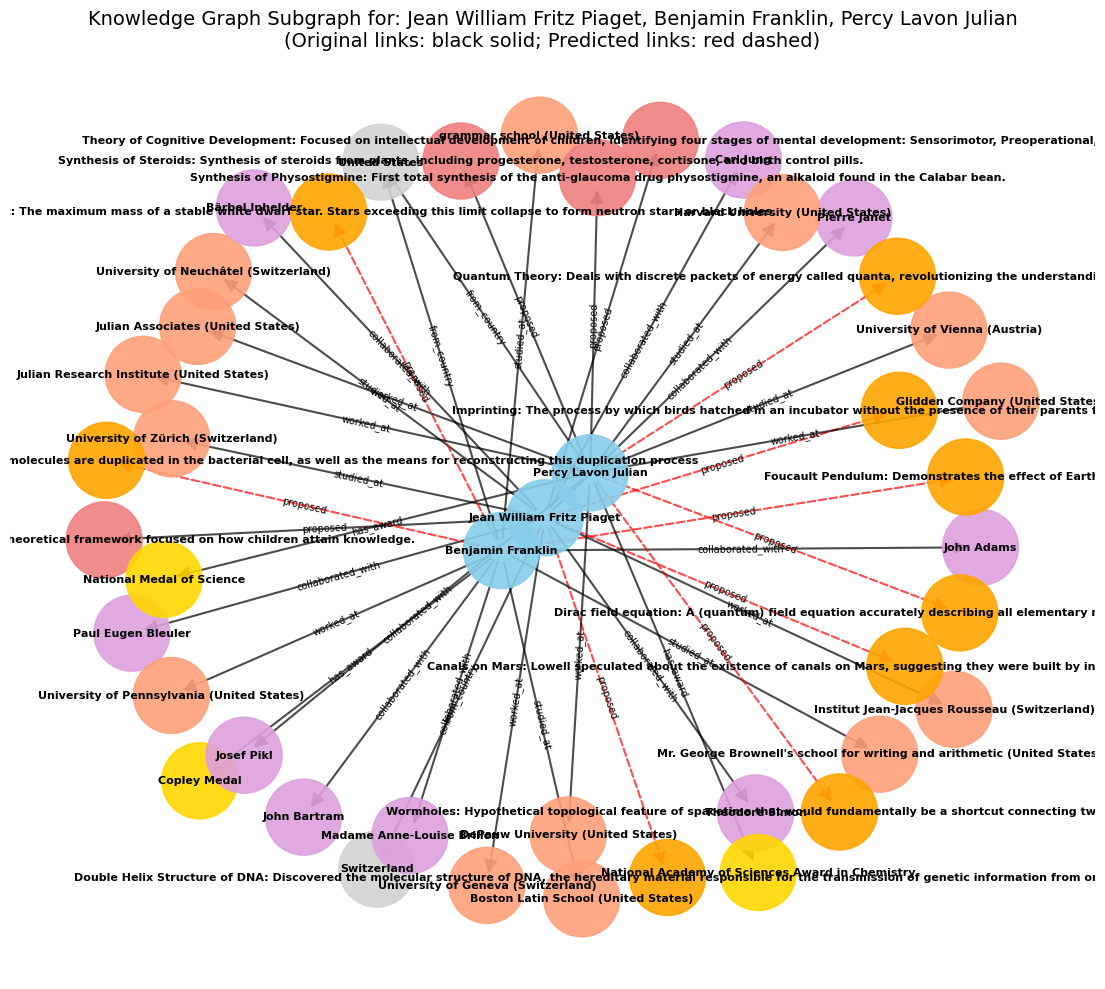


Note: The full knowledge graph can be very large and complex, making a complete visualization unreadable. This visualization shows subgraphs around selected scientists, including both original and newly predicted 'proposed' links. Original links are black solid, and predicted links are red dashed.
You can modify the `scientists_to_show_ids` list in the `visualize_knowledge_graph_subset` call to view different parts of the completed graph.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import HeteroData
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import ast
import random
import numpy as np
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

# Load your existing dataframes
awards_df = pd.read_csv('awards.csv')
collaborations_df = pd.read_csv('collaborations.csv')
countries_df = pd.read_csv('countries.csv')
institutes_studied_df = pd.read_csv('institutes_studied.csv')
institutes_worked_df = pd.read_csv('institutes_worked.csv')
scientists_df = pd.read_csv('scientists.csv')
theories_df = pd.read_csv('theories.csv')

# Drop 'collaborated_scientists' from theories_df as it's not used in your graph construction
theories_df = theories_df.drop('collaborated_scientists', axis=1, errors='ignore')

# --- Helper to safely parse dict-like strings ---
def parse_dict(item):
    """
    Safely parses a string that might represent a dictionary into a dictionary.
    Handles cases where the input is already a dictionary or cannot be parsed.
    """
    if isinstance(item, str):
        try:
            return ast.literal_eval(item)
        except (ValueError, SyntaxError):
            return {}
    return item

# --- Mapping IDs and collecting unique entities ---
# Create a mapping for scientist IDs to their names
scientist_map = scientists_df.set_index('id')['name'].to_dict()
scientist_name_to_id = {name: id for id, name in scientist_map.items()}

# Collect all unique institution names from both 'institutes_studied' and 'institutes_worked'
all_institutions = pd.concat([institutes_studied_df['name'], institutes_worked_df['name']]).unique()
# Create a numerical ID mapping for institutions
institution_map = {name: i for i, name in enumerate(all_institutions)}
institution_id_to_name = {i: name for name, i in institution_map.items()} # Reverse map

# Collect all unique award names from the 'award_dict' column
all_award_names = list(set(chain.from_iterable([parse_dict(d).keys() for d in awards_df['award_dict'] if pd.notna(d)])))
# Create a numerical ID mapping for awards
award_map = {name: i for i, name in enumerate(all_award_names)}
award_id_to_name = {i: name for name, i in award_map.items()} # Reverse map

# Collect all unique theory descriptions
all_theories = theories_df['description'].unique()
# Create a numerical ID mapping for theories
theory_map = {name: i for i, name in enumerate(all_theories)}
theory_id_to_name = {i: name for name, i in theory_map.items()} # Reverse map

# Collect all unique country names
all_countries = countries_df['name'].unique()
# Create a numerical ID mapping for countries
country_map = {name: i for i, name in enumerate(all_countries)}
country_id_to_name = {i: name for name, i in country_map.items()} # Reverse map

# Collect all unique collaborators (assuming 'scientists' column in collaborations_df contains collaborator names)
all_collaborators = collaborations_df['scientists'].unique()
# Create a numerical ID mapping for collaborators
collaborator_map = {name: i for i, name in enumerate(all_collaborators)}
collaborator_id_to_name = {i: name for name, i in collaborator_map.items()} # Reverse map

# --- Build Edge Triplets ---
# Initialize a list to store all (source_id, relation, destination_id) triplets
edge_triplets = []

# Add edges for 'studied_at' relation
for _, row in institutes_studied_df.iterrows():
    scientist_id = row['id']
    institution_name = row['name']
    if institution_name in institution_map:
        edge_triplets.append([scientist_id, 'studied_at', institution_map[institution_name]])

# Add edges for 'worked_at' relation
for _, row in institutes_worked_df.iterrows():
    scientist_id = row['id']
    institution_name = row['name']
    if institution_name in institution_map:
        edge_triplets.append([scientist_id, 'worked_at', institution_map[institution_name]])

# Add edges for 'proposed' relation
for _, row in theories_df.iterrows():
    scientist_id = row['id']
    theory_description = row['description']
    if theory_description in theory_map:
        edge_triplets.append([scientist_id, 'proposed', theory_map[theory_description]])

# Add edges for 'from_country' relation
for _, row in countries_df.iterrows():
    scientist_id = row['id']
    country_name = row['name']
    if country_name in country_map:
        edge_triplets.append([scientist_id, 'from_country', country_map[country_name]])

# Add edges for 'collaborated_with' relation
for _, row in collaborations_df.iterrows():
    scientist_id = row['id']
    collaborator_name = row['scientists']
    if collaborator_name in collaborator_map:
        edge_triplets.append([scientist_id, 'collaborated_with', collaborator_map[collaborator_name]])

# Add edges for 'has_award' relation
for _, row in awards_df.iterrows():
    src = row['scientist_id']
    award_dict = parse_dict(row['award_dict'])
    for award_name in award_dict.keys():
        if award_name in award_map:
            dst = award_map[award_name]
            edge_triplets.append([src, 'has_award', dst])

# Create a DataFrame for all original edges
edges_df = pd.DataFrame(edge_triplets, columns=['source_id', 'relation', 'destination_id'])
edges_df['is_predicted'] = False # Mark original edges as not predicted
edges_df.to_csv('edges.csv', index=False)
print("\n--- Original edges.csv created successfully ---\n")

# --- Embedding Features ---
# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each node type based on their descriptions/names
scientist_features = model.encode(scientists_df['description'].fillna('').tolist(), convert_to_tensor=True)
institution_features = model.encode(list(institution_map.keys()), convert_to_tensor=True)
award_descs = []
for d in awards_df['award_dict']:
    ad = parse_dict(d)
    for k, v in ad.items():
        desc = v if v != 'NA' else 'an unspecified honor'
        award_descs.append(f"{k}: {desc}")
award_features = model.encode(award_descs, convert_to_tensor=True)
theory_features = model.encode(list(theory_map.keys()), convert_to_tensor=True)
country_features = model.encode(list(country_map.keys()), convert_to_tensor=True)
collaborator_features = model.encode(list(collaborator_map.keys()), convert_to_tensor=True)

# --- Construct PyG HeteroData Object ---
data = HeteroData()
# Assign node features
data['scientist'].x = scientist_features
data['institution'].x = institution_features
data['award'].x = award_features
data['theory'].x = theory_features
data['country'].x = country_features
data['collaborator'].x = collaborator_features

# Define the mapping from relation string to PyG triplet format
relation_to_triplet = {
    'studied_at': ('scientist', 'studied_at', 'institution'),
    'worked_at': ('scientist', 'worked_at', 'institution'),
    'has_award': ('scientist', 'has_award', 'award'),
    'proposed': ('scientist', 'proposed', 'theory'),
    'from_country': ('scientist', 'from_country', 'country'),
    'collaborated_with': ('scientist', 'collaborated_with', 'collaborator')
}

# Populate edge indices for PyG HeteroData
edges_dict = defaultdict(lambda: {'source': [], 'destination': []})
for _, row in edges_df.iterrows():
    relation = row['relation']
    triplet_type = relation_to_triplet[relation]

    src_node_type = triplet_type[0]
    dst_node_type = triplet_type[2]

    src_id = row['source_id']
    dst_id = row['destination_id']

    # Handle mapping for source nodes
    if src_node_type == 'scientist':
        src_idx = scientists_df[scientists_df['id'] == src_id].index[0]
    else:
        src_idx = src_id

    # Handle mapping for destination nodes
    if dst_node_type == 'scientist':
        dst_idx = scientists_df[scientists_df['id'] == dst_id].index[0]
    else:
        dst_idx = dst_id

    edges_dict[relation]['source'].append(src_idx)
    edges_dict[relation]['destination'].append(dst_idx)


for relation, nodes in edges_dict.items():
    triplet = relation_to_triplet[relation]
    src_nodes = torch.tensor(nodes['source'], dtype=torch.long)
    dst_nodes = torch.tensor(nodes['destination'], dtype=torch.long)
    data[triplet].edge_index = torch.stack([src_nodes, dst_nodes], dim=0)

print("PyG HeteroData object created successfully:\n", data)

# --- Knowledge Graph Completion (Link Prediction) ---

# 1. Prepare Data for Link Prediction
# We'll focus on 'scientist' -> 'proposed' -> 'theory' relation as an example.
positive_samples_orig_ids = []
for _, row in theories_df.iterrows():
    scientist_id = row['id']
    theory_description = row['description']
    if theory_description in theory_map:
        positive_samples_orig_ids.append((scientist_id, theory_map[theory_description]))

all_scientist_orig_ids = scientists_df['id'].unique().tolist()
all_theory_mapped_ids = list(theory_map.values())
all_possible_pairs_orig_ids = set((s, t) for s in all_scientist_orig_ids for t in all_theory_mapped_ids)

existing_pairs_orig_ids = set(tuple(p) for p in positive_samples_orig_ids)
negative_candidates_orig_ids = list(all_possible_pairs_orig_ids - existing_pairs_orig_ids)

num_negative_samples = len(positive_samples_orig_ids)
if len(negative_candidates_orig_ids) < num_negative_samples:
    print(f"Warning: Not enough unique negative samples. Using all {len(negative_candidates_orig_ids)} available.")
    negative_samples_orig_ids = negative_candidates_orig_ids
else:
    negative_samples_orig_ids = random.sample(negative_candidates_orig_ids, num_negative_samples)

print(f"\nNumber of positive samples: {len(positive_samples_orig_ids)}")
print(f"Number of negative samples: {len(negative_samples_orig_ids)}")

all_samples_orig_ids = [(h, t, 1) for h, t in positive_samples_orig_ids] + [(h, t, 0) for h, t in negative_samples_orig_ids]
random.shuffle(all_samples_orig_ids)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_total = len(all_samples_orig_ids)
num_train = int(train_ratio * num_total)
num_val = int(val_ratio * num_total)

train_data_orig_ids = all_samples_orig_ids[:num_train]
val_data_orig_ids = all_samples_orig_ids[num_train:num_train + num_val]
test_data_orig_ids = all_samples_orig_ids[num_train + num_val:]

print(f"Train samples: {len(train_data_orig_ids)}, Validation samples: {len(val_data_orig_ids)}, Test samples: {len(test_data_orig_ids)}")

# 2. Define a simple Link Prediction Model (TransE-like)
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        nn.init.xavier_uniform_(self.relation_embeddings.weight.data)

        self.entity_embeddings.weight.data = torch.nn.functional.normalize(
            self.entity_embeddings.weight.data, p=2, dim=1
        )

    def forward(self, head_indices, relation_indices, tail_indices):
        head_emb = self.entity_embeddings(head_indices)
        relation_emb = self.relation_embeddings(relation_indices)
        tail_emb = self.entity_embeddings(tail_indices)
        score = torch.norm(head_emb + relation_emb - tail_emb, p=2, dim=1)
        return score

relation_id_map = {'proposed': 0}
num_relations = len(relation_id_map)

max_scientist_id = scientists_df['id'].max()
scientist_unified_map = {s_id: s_id for s_id in scientists_df['id'].unique()}
theory_unified_map = {t_mapped_id: i + max_scientist_id + 1 for i, t_mapped_id in enumerate(theory_map.values())}

num_entities = max_scientist_id + 1 + len(theory_map)

embedding_dim = 128

model_lp = TransE(num_entities, num_relations, embedding_dim)
optimizer = optim.Adam(model_lp.parameters(), lr=0.01)
loss_fn = nn.MarginRankingLoss(margin=1.0)

# 3. Train the Model
epochs = 50
batch_size = 64

def get_batch(data_list, batch_size, is_training=True):
    for i in range(0, len(data_list), batch_size):
        batch = data_list[i:i + batch_size]
        heads_orig_ids = [s[0] for s in batch]
        tails_mapped_ids = [s[1] for s in batch]
        labels = torch.tensor([s[2] for s in batch], dtype=torch.float)

        heads_unified = torch.tensor([scientist_unified_map[h_orig] for h_orig in heads_orig_ids], dtype=torch.long)
        tails_unified = torch.tensor([theory_unified_map[t_mapped] for t_mapped in tails_mapped_ids], dtype=torch.long)
        relations = torch.tensor([relation_id_map['proposed']] * len(batch), dtype=torch.long)

        if is_training:
            corrupted_heads_unified = []
            corrupted_tails_unified = []
            for h_orig, t_mapped, label in batch:
                if label == 1:
                    if random.random() > 0.5:
                        corrupted_h_orig = random.choice(all_scientist_orig_ids)
                        while (corrupted_h_orig, t_mapped) in existing_pairs_orig_ids:
                            corrupted_h_orig = random.choice(all_scientist_orig_ids)
                        corrupted_heads_unified.append(scientist_unified_map[corrupted_h_orig])
                        corrupted_tails_unified.append(theory_unified_map[t_mapped])
                    else:
                        corrupted_t_mapped = random.choice(all_theory_mapped_ids)
                        while (h_orig, corrupted_t_mapped) in existing_pairs_orig_ids:
                            corrupted_t_mapped = random.choice(all_theory_mapped_ids)
                        corrupted_heads_unified.append(scientist_unified_map[h_orig])
                        corrupted_tails_unified.append(theory_unified_map[corrupted_t_mapped])
                else:
                    corrupted_heads_unified.append(scientist_unified_map[h_orig])
                    corrupted_tails_unified.append(theory_unified_map[t_mapped])

            corrupted_heads_unified = torch.tensor(corrupted_heads_unified, dtype=torch.long)
            corrupted_tails_unified = torch.tensor(corrupted_tails_unified, dtype=torch.long)

            yield heads_unified, relations, tails_unified, corrupted_heads_unified, corrupted_tails_unified
        else:
            yield heads_unified, relations, tails_unified, labels


print("\n--- Starting Link Prediction Training ---")
for epoch in range(epochs):
    model_lp.train()
    total_loss = 0
    for heads, relations, tails, corrupted_heads, corrupted_tails in get_batch(train_data_orig_ids, batch_size, is_training=True):
        optimizer.zero_grad()
        positive_scores = model_lp(heads, relations, tails)
        negative_scores = model_lp(corrupted_heads, relations, corrupted_tails)
        loss = loss_fn(positive_scores, negative_scores, torch.tensor([-1.0]))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model_lp.eval()
    with torch.no_grad():
        pass # Simplified validation for brevity in this example
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

print("\n--- Training Complete ---")

# 4. Evaluate the Model (Hits@k, MRR)
def evaluate_link_prediction(model, test_data, scientist_unified_map, theory_unified_map, relation_id_map, existing_triplets_set, k_values=[1, 3, 10]):
    model.eval()
    hits_at_k = {k: 0 for k in k_values}
    mean_rank = []
    mean_reciprocal_rank = []

    all_scientist_orig_ids = list(scientist_unified_map.keys())
    all_theory_mapped_ids = list(theory_map.values())

    with torch.no_grad():
        for h_orig, t_mapped, label in test_data:
            if label == 0:
                continue

            true_head_unified_id = scientist_unified_map[h_orig]
            true_tail_unified_id = theory_unified_map[t_mapped]
            relation_id = relation_id_map['proposed']

            # Corrupt head
            ranks_h = []
            for candidate_head_orig_id in all_scientist_orig_ids:
                candidate_head_unified_id = scientist_unified_map[candidate_head_orig_id]
                score = model(
                    torch.tensor([candidate_head_unified_id], dtype=torch.long),
                    torch.tensor([relation_id], dtype=torch.long),
                    torch.tensor([true_tail_unified_id], dtype=torch.long)
                ).item()
                is_true_candidate = (candidate_head_orig_id == h_orig)
                if not is_true_candidate and (candidate_head_orig_id, t_mapped) in existing_triplets_set:
                    continue
                ranks_h.append((score, is_true_candidate))

            ranks_h.sort(key=lambda x: x[0])
            rank_h = 0
            for i, (score, is_true) in enumerate(ranks_h):
                if is_true:
                    rank_h = i + 1
                    break
            if rank_h > 0:
                mean_rank.append(rank_h)
                mean_reciprocal_rank.append(1.0 / rank_h)
                for k in k_values:
                    if rank_h <= k:
                        hits_at_k[k] += 1

            # Corrupt tail
            ranks_t = []
            for candidate_tail_mapped_id in all_theory_mapped_ids:
                candidate_tail_unified_id = theory_unified_map[candidate_tail_mapped_id]
                score = model(
                    torch.tensor([true_head_unified_id], dtype=torch.long),
                    torch.tensor([relation_id], dtype=torch.long),
                    torch.tensor([candidate_tail_unified_id], dtype=torch.long)
                ).item()
                is_true_candidate = (candidate_tail_mapped_id == t_mapped)
                if not is_true_candidate and (h_orig, candidate_tail_mapped_id) in existing_triplets_set:
                    continue
                ranks_t.append((score, is_true_candidate))

            ranks_t.sort(key=lambda x: x[0])
            rank_t = 0
            for i, (score, is_true) in enumerate(ranks_t):
                if is_true:
                    rank_t = i + 1
                    break
            if rank_t > 0:
                mean_rank.append(rank_t)
                mean_reciprocal_rank.append(1.0 / rank_t)
                for k in k_values:
                    if rank_t <= k:
                        hits_at_k[k] += 1

    num_eval_triplets = len([s for s in test_data if s[2] == 1]) * 2
    print(f"\n--- Link Prediction Evaluation Results ({'scientist'} --[proposed]--> {'theory'}) ---")
    print(f"Total evaluated triplets (after corruption): {num_eval_triplets}")
    for k in k_values:
        print(f"Hits@{k}: {hits_at_k[k] / num_eval_triplets:.4f}")
    print(f"Mean Rank (MR): {np.mean(mean_rank):.4f}")
    print(f"Mean Reciprocal Rank (MRR): {np.mean(mean_reciprocal_rank):.4f}")


# Perform evaluation
evaluate_link_prediction(model_lp, test_data_orig_ids, scientist_unified_map, theory_unified_map, relation_id_map, existing_pairs_orig_ids)


# --- Predict and Add New Links for ALL Scientists ---
print("\n--- Predicting and Adding New Links for All Scientists ---")

all_predicted_new_links = []
top_n_predictions_per_scientist = 3 # Number of top predicted links to add for each scientist
prediction_score_threshold = 0.5 # Alternative: only add if score is below this threshold

all_theories_list = list(theory_map.keys())
all_theories_mapped_ids = list(theory_map.values())
all_theories_unified_ids = [theory_unified_map[t_mapped_id] for t_mapped_id in all_theories_mapped_ids]
proposed_relation_id = relation_id_map['proposed']

for scientist_id in all_scientist_orig_ids:
    if scientist_id not in scientist_unified_map:
        continue # Skip if scientist not in unified map (shouldn't happen with current mapping)

    target_scientist_unified_id = scientist_unified_map[scientist_id]
    prediction_scores = []

    with torch.no_grad():
        for i, theory_unified_id in enumerate(all_theories_unified_ids):
            current_theory_mapped_id = all_theories_mapped_ids[i]
            # Only consider non-existing links for prediction
            if (scientist_id, current_theory_mapped_id) not in existing_pairs_orig_ids:
                score = model_lp(
                    torch.tensor([target_scientist_unified_id], dtype=torch.long),
                    torch.tensor([proposed_relation_id], dtype=torch.long),
                    torch.tensor([theory_unified_id], dtype=torch.long)
                ).item()
                prediction_scores.append((score, all_theories_list[i], current_theory_mapped_id))

    prediction_scores.sort(key=lambda x: x[0]) # Sort by score (lower is better)

    # Add top N predictions (or based on a threshold)
    for i, (score, theory_desc, theory_mapped_id) in enumerate(prediction_scores):
        if i >= top_n_predictions_per_scientist:
            break
        # Optional: Add a score threshold check here as well: `if score < prediction_score_threshold:`
        all_predicted_new_links.append({
            'source_id': scientist_id,
            'relation': 'proposed',
            'destination_id': theory_mapped_id,
            'is_predicted': True # Mark as predicted
        })

print(f"Total new predicted links added: {len(all_predicted_new_links)}")

# Create a DataFrame for new predicted links
predicted_edges_df = pd.DataFrame(all_predicted_new_links)

# Combine original and predicted edges to form the complete graph
completed_edges_df = pd.concat([edges_df, predicted_edges_df], ignore_index=True)
print(f"Total edges in the completed knowledge graph: {len(completed_edges_df)}")


# --- Knowledge Graph Visualization ---

def visualize_knowledge_graph_subset(
    scientist_ids_to_visualize, # Now accepts a list of scientist IDs
    num_predicted_links_to_show=3, # Max predicted links to show per scientist in visualization
    model_lp=model_lp,
    scientist_map=scientist_map,
    theory_map=theory_map,
    institution_map=institution_map,
    award_map=award_map,
    country_map=country_map,
    collaborator_map=collaborator_map,
    scientist_unified_map=scientist_unified_map,
    theory_unified_map=theory_unified_map,
    relation_id_map=relation_id_map,
    existing_pairs_orig_ids=existing_pairs_orig_ids,
    completed_edges_df=completed_edges_df, # Use the completed DataFrame
    scientists_df=scientists_df
):
    """
    Visualizes a subgraph centered around a specific scientist (or scientists),
    including existing and newly predicted links from the completed graph.
    """
    G = nx.DiGraph()

    # Collect nodes and edges relevant to the specified scientists
    subgraph_nodes = set()
    subgraph_edges = []

    for scientist_id in scientist_ids_to_visualize:
        # Add the target scientist node
        target_scientist_name = scientist_map.get(scientist_id, f"Scientist_{scientist_id}")
        G.add_node(f"S_{scientist_id}", label=target_scientist_name, type='scientist', color='skyblue')
        subgraph_nodes.add(f"S_{scientist_id}")

        # Add existing and predicted edges for the target scientist from the completed_edges_df
        scientist_related_edges = completed_edges_df[completed_edges_df['source_id'] == scientist_id]

        for _, row in scientist_related_edges.iterrows():
            src_id_orig = row['source_id']
            relation = row['relation']
            dst_id_mapped = row['destination_id']
            is_predicted = row['is_predicted']

            src_node_label = f"S_{src_id_orig}"

            dst_node_label = ""
            dst_node_type = ""
            dst_color = 'lightgreen' # Default for non-scientist nodes
            edge_color = 'black'
            edge_style = 'solid'

            if is_predicted:
                edge_color = 'red'
                edge_style = 'dashed'
                dst_color = 'orange' # Highlight predicted nodes

            if relation == 'proposed':
                dst_node_label = f"T_{dst_id_mapped}"
                dst_node_type = 'theory'
                if not is_predicted: dst_color = 'lightcoral'
                G.add_node(dst_node_label, label=theory_id_to_name.get(dst_id_mapped, f"Theory_{dst_id_mapped}"), type=dst_node_type, color=dst_color)
            elif relation == 'studied_at' or relation == 'worked_at':
                dst_node_label = f"Inst_{dst_id_mapped}"
                dst_node_type = 'institution'
                if not is_predicted: dst_color = 'lightsalmon'
                G.add_node(dst_node_label, label=institution_id_to_name.get(dst_id_mapped, f"Institution_{dst_id_mapped}"), type=dst_node_type, color=dst_color)
            elif relation == 'has_award':
                dst_node_label = f"A_{dst_id_mapped}"
                dst_node_type = 'award'
                if not is_predicted: dst_color = 'gold'
                G.add_node(dst_node_label, label=award_id_to_name.get(dst_id_mapped, f"Award_{dst_id_mapped}"), type=dst_node_type, color=dst_color)
            elif relation == 'from_country':
                dst_node_label = f"C_{dst_id_mapped}"
                dst_node_type = 'country'
                if not is_predicted: dst_color = 'lightgray'
                G.add_node(dst_node_label, label=country_id_to_name.get(dst_id_mapped, f"Country_{dst_id_mapped}"), type=dst_node_type, color=dst_color)
            elif relation == 'collaborated_with':
                dst_node_label = f"Collab_{dst_id_mapped}"
                dst_node_type = 'collaborator'
                if not is_predicted: dst_color = 'plum'
                G.add_node(dst_node_label, label=collaborator_id_to_name.get(dst_id_mapped, f"Collaborator_{dst_id_mapped}"), type=dst_node_type, color=dst_color)
            else:
                dst_node_label = f"Unknown_{dst_id_mapped}"
                dst_node_type = 'unknown'
                dst_color = 'white'
                G.add_node(dst_node_label, label=f"Unknown_{dst_id_mapped}", type=dst_node_type, color=dst_color)

            G.add_edge(src_node_label, dst_node_label, relation=relation, style=edge_style, color=edge_color)
            subgraph_nodes.add(dst_node_label)
            subgraph_edges.append((src_node_label, dst_node_label))


    # Draw the graph
    plt.figure(figsize=(14, 12)) # Increased figure size
    pos = nx.spring_layout(G, k=0.8, iterations=50) # positions for all nodes

    node_colors = [G.nodes[node].get('color', 'lightgray') for node in G.nodes()]
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes()}

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold')

    edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges()]
    edge_styles = [G.edges[edge].get('style', 'solid') for edge in G.edges()]
    edge_labels = nx.get_edge_attributes(G, 'relation')

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, style=edge_styles, width=1.5, alpha=0.7, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, bbox=dict(facecolor='white', alpha=0.0))

    scientist_names = [scientist_map.get(sid, f"Scientist_{sid}") for sid in scientist_ids_to_visualize]
    title_str = "Knowledge Graph Subgraph for: " + ", ".join(scientist_names)
    plt.title(f"{title_str}\n(Original links: black solid; Predicted links: red dashed)", fontsize=14)
    plt.axis('off')
    plt.show()

# --- Example Usage of Visualization with Completed Graph ---

# Get a few scientist IDs to visualize their subgraphs from the completed graph
# You can choose specific IDs or a random sample
scientists_to_show_ids = scientists_df['id'].sample(min(3, len(scientists_df))).tolist() # Sample up to 3 scientists

print(f"\n--- Visualizing Subgraphs from the Completed Knowledge Graph for Scientists: {', '.join([scientist_map.get(sid, str(sid)) for sid in scientists_to_show_ids])} ---")
visualize_knowledge_graph_subset(scientists_to_show_ids, num_predicted_links_to_show=3)

print("\nNote: The full knowledge graph can be very large and complex, making a complete visualization unreadable. This visualization shows subgraphs around selected scientists, including both original and newly predicted 'proposed' links. Original links are black solid, and predicted links are red dashed.")
print("You can modify the `scientists_to_show_ids` list in the `visualize_knowledge_graph_subset` call to view different parts of the completed graph.")